Saved SI raster: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_suitability/suitability_index_0_1.tif


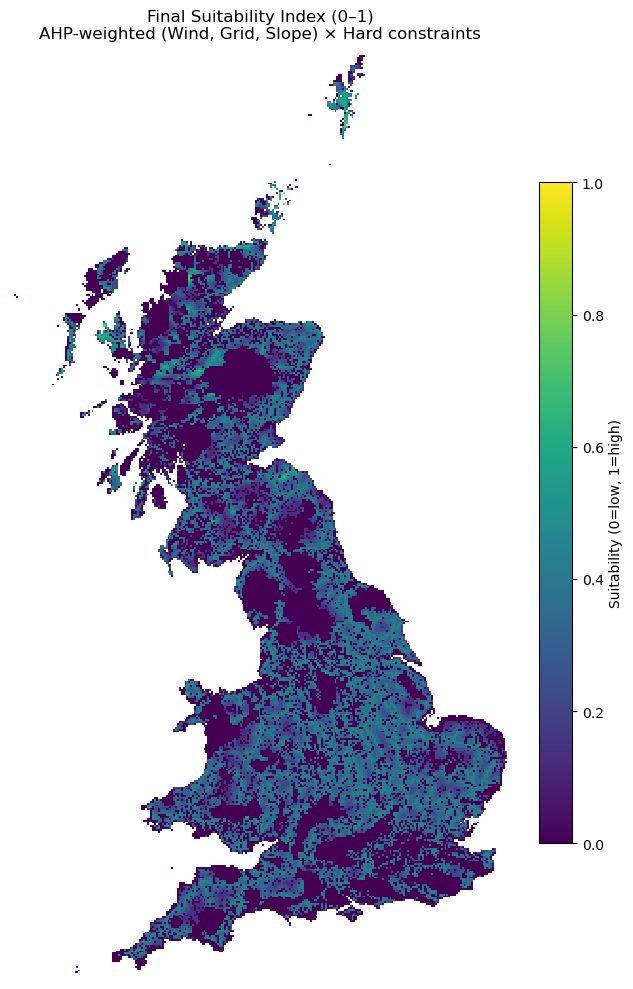

Saved SI map PNG: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_suitability/suitability_index_0_1.png

--- SI stats (onshore, after hard constraints) ---
Valid pixels: 37685
Mean SI: 0.1731881946325302
P90 SI: 0.42000001668930054
P95 SI: 0.42000001668930054
P99 SI: 0.5006591081619263


In [1]:
# ============================================================
# AHP weighted suitability index (SI) + Hard mask
# Inputs: wind/slope/grid suitability rasters (0-1) + hard mask (0/1, nodata=255)
# Output:
#   - suitability_index_0_1.tif  (float32, nodata=-9999)
#   - suitability_index_0_1.png  (for report)
# Notes:
#   - Uses WarpedVRT to align rasters to hard-mask grid safely (CRS/res mismatch OK)
#   - Block-wise processing to avoid memory blow-up
# ============================================================

import os
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
import matplotlib.pyplot as plt


DATA_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"

HARD_MASK_TIF = os.path.join(DATA_DIR, "outputs_constraints", "final_hard_mask_0_1.tif")
WIND_SUIT_TIF = os.path.join(DATA_DIR, "outputs", "wind_suitability_match_dem.tif")
SLOPE_SUIT_TIF = os.path.join(DATA_DIR, "outputs", "slope_suitability_continuous_epsg27700.tif")
GRID_SUIT_TIF = os.path.join(DATA_DIR, "outputs", "grid_suitability_0_1_piecewise.tif")

OUT_DIR = os.path.join(DATA_DIR, "outputs_suitability")
os.makedirs(OUT_DIR, exist_ok=True)

OUT_SI_TIF = os.path.join(OUT_DIR, "suitability_index_0_1.tif")
OUT_SI_PNG = os.path.join(OUT_DIR, "suitability_index_0_1.png")


W_WIND  = 0.58
W_GRID  = 0.31
W_SLOPE = 0.11


OUT_NODATA = -9999.0


with rasterio.open(HARD_MASK_TIF) as ref:

    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_width = ref.width
    ref_height = ref.height

    out_profile = ref.profile.copy()
    out_profile.update(
        driver="GTiff",
        dtype="float32",
        count=1,
        nodata=OUT_NODATA,
        compress="lzw"
    )


    wind_vrt = WarpedVRT(
        rasterio.open(WIND_SUIT_TIF),
        crs=ref_crs,
        transform=ref_transform,
        width=ref_width,
        height=ref_height,
        resampling=Resampling.bilinear,
        nodata=np.nan
    )

    slope_vrt = WarpedVRT(
        rasterio.open(SLOPE_SUIT_TIF),
        crs=ref_crs,
        transform=ref_transform,
        width=ref_width,
        height=ref_height,
        resampling=Resampling.bilinear,
        nodata=np.nan
    )

    grid_vrt = WarpedVRT(
        rasterio.open(GRID_SUIT_TIF),
        crs=ref_crs,
        transform=ref_transform,
        width=ref_width,
        height=ref_height,
        resampling=Resampling.bilinear,
        nodata=np.nan
    )

  
    with rasterio.open(OUT_SI_TIF, "w", **out_profile) as dst:

        for _, window in ref.block_windows(1):
            hard = ref.read(1, window=window)

            # hard mask logic: 0/1 on onshore; 255 is nodata outside onshore
            hard_valid = (hard != 255)
            hard01 = np.where(hard_valid, hard, 0).astype(np.float32)

            # Read aligned suitability layers (0-1)
            wind  = wind_vrt.read(1, window=window).astype(np.float32)
            slope = slope_vrt.read(1, window=window).astype(np.float32)
            grid  = grid_vrt.read(1, window=window).astype(np.float32)

            # Replace nan with 0 to avoid propagating; final masking by hard01 anyway
            wind  = np.nan_to_num(wind,  nan=0.0)
            slope = np.nan_to_num(slope, nan=0.0)
            grid  = np.nan_to_num(grid,  nan=0.0)

            # Weighted sum (0-1) then apply hard mask
            si = (W_WIND * wind + W_GRID * grid + W_SLOPE * slope) * hard01

            # Outside onshore -> nodata
            si = np.where(hard_valid, si, OUT_NODATA).astype(np.float32)

            dst.write(si, 1, window=window)

   
    wind_vrt.close()
    slope_vrt.close()
    grid_vrt.close()

print("Saved SI raster:", OUT_SI_TIF)

with rasterio.open(OUT_SI_TIF) as src:
    si = src.read(1).astype(np.float32)
    nodata = src.nodata
    si = np.where(si == nodata, np.nan, si)

plt.figure(figsize=(8, 10))
cmap = plt.cm.viridis.copy()
cmap.set_bad("white")  # outside onshore

im = plt.imshow(si, vmin=0, vmax=1, cmap=cmap, interpolation="nearest")
plt.title("Final Suitability Index (0–1)\nAHP-weighted (Wind, Grid, Slope) × Hard constraints")
plt.axis("off")
plt.colorbar(im, fraction=0.046, pad=0.04, label="Suitability (0=low, 1=high)")
plt.tight_layout()
plt.savefig(OUT_SI_PNG, dpi=300)
plt.show()

print("Saved SI map PNG:", OUT_SI_PNG)


valid = np.isfinite(si)
if valid.sum() > 0:
    print("\n--- SI stats (onshore, after hard constraints) ---")
    print("Valid pixels:", int(valid.sum()))
    print("Mean SI:", float(np.nanmean(si)))
    print("P90 SI:", float(np.nanpercentile(si, 90)))
    print("P95 SI:", float(np.nanpercentile(si, 95)))
    print("P99 SI:", float(np.nanpercentile(si, 99)))
else:
    print("No valid SI pixels. Check inputs / masks.")
